# Sequence Models

Generate our sequence data by using a sine function with some additive noise for time steps $1, 2, \ldots, 1000$

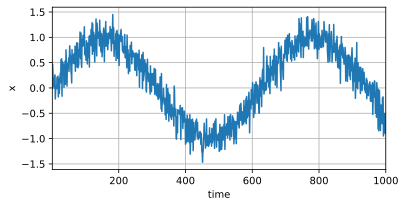

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

Construct examples with labels $y_t = x_t$ and features $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))
features.shape, labels.shape

(torch.Size([996, 4]), torch.Size([996, 1]))

Create a data iterator on the first 600 examples

In [4]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

A single-hidden-layer MLP with the ReLU activation and squared loss

In [5]:
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    return net

loss = nn.MSELoss()

Train the model

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.049992
epoch 2, loss: 0.046857
epoch 3, loss: 0.046668
epoch 4, loss: 0.046259
epoch 5, loss: 0.047945


Predicting what happens just in the next time step

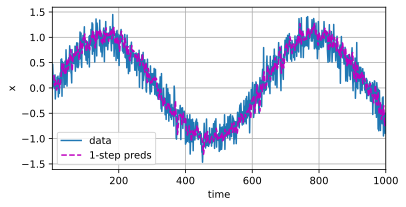

In [7]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

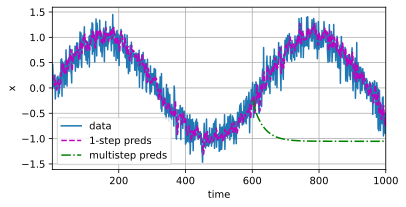

In [9]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds',
                 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

Take a closer look at the difficulties in $k$-step-ahead predictions

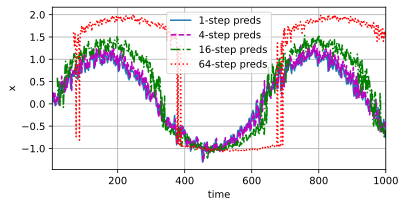

In [11]:
def k_step_pred(k):
    features = torch.zeros((T - tau - k + 1, tau + k))
    for i in range(tau):
        features[:, i] = x[i:i + T - tau - k + 1]
    for i in range(k):
        features[:, i + tau] = net(features[:, i:i + tau]).reshape(-1)
    return features[:, -1]

steps = (1, 4, 16, 64)
d2l.plot([time[tau + k - 1:]
          for k in steps], [k_step_pred(k).detach().numpy() for k in steps],
         'time', 'x', legend=[f'{k}-step preds' for k in steps],
         xlim=[5, 1000], figsize=(6, 3))